## Importing the Necessary Libraries

In [1]:
!pip install tld 
import tldextract
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from urllib.parse import urlparse
from tld import get_tld
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Flatten, Dropout,  SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score
import pickle

## Loading the Data

In [2]:
# Function to load data and add labels
def load_data(file_path, label):
    df = pd.read_csv(file_path, header=None, names=['URL'])
    df['Label'] = label
    return df

# Load each dataset
# Replace 'path_to_file.csv' with the actual file paths
benign_df = load_data('URL/Benign_list_big_final.csv', 'Benign')
defacement_df = load_data('URL/DefacementSitesURLFiltered.csv', 'Malicious')
malware_df = load_data('URL/Malware_dataset.csv', 'Malicious')
phishing_df = load_data('URL/phishing_dataset.csv', 'Malicious')
spam_df = load_data('URL/spam_dataset.csv', 'Malicious')

# Concatenating all data into a single DataFrame
data = pd.concat([benign_df, defacement_df, malware_df, phishing_df, spam_df], ignore_index=True)

# Optionally, save the combined dataframe to a new CSV file for easy access
data.to_csv('combined_url_data.csv', index=False)

# Display the first few rows of the combined dataframe
display(data.head())

,URL,Label
0,http://1337x.to/torrent/1048648/American-Snipe...,Benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,Benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,Benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,Benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,Benign


## Statistical Analysis

In [3]:
# Display the shape of the DataFrame
print("Shape of the DataFrame:", data.shape)

# Display basic information about the DataFrame
print("\nDataFrame Information:")
print(data.info())

# Display data types of each column
print("\nData Types of Columns:")
print(data.dtypes)

# Display a basic statistical description of the DataFrame
# For non-numeric columns, it will include count, unique, top, freq
print("\nStatistical Description:")
display(data.describe(include='all'))

Shape of the DataFrame: (165366, 2)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165366 entries, 0 to 165365
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     165366 non-null  object
 1   Label   165366 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB
None

Data Types of Columns:
URL      object
Label    object
dtype: object

Statistical Description:


,URL,Label
count,165366,165366
unique,155254,2
top,http://style.org.hc360.com/css/detail/mysite/s...,Malicious
freq,180,129988


In [4]:
# Counting empty values in each column
empty_values_count = data.isnull().sum()

# Displaying the count of empty values
print("Count of Empty Values in Each Column:")
print(empty_values_count)

Count of Empty Values in Each Column:
URL      0
Label    0
dtype: int64


## Exploratory Data Analysis

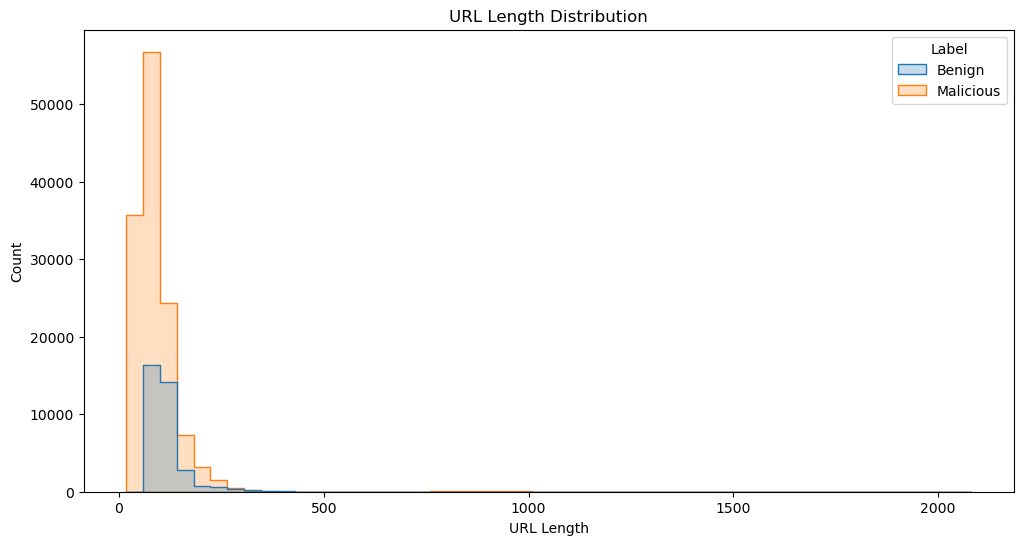

In [5]:
# Calculating URL length
data['URL_Length'] = data['URL'].apply(len)

# Plotting histogram/bar chart for URL length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='URL_Length', hue='Label', element='step', bins=50)
plt.title('URL Length Distribution')
plt.xlabel('URL Length')
plt.ylabel('Count')
plt.show()

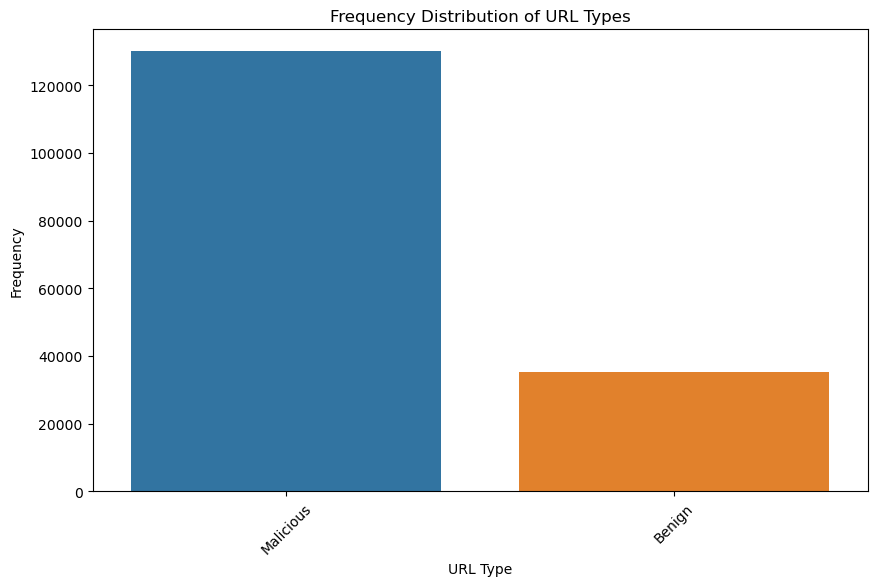

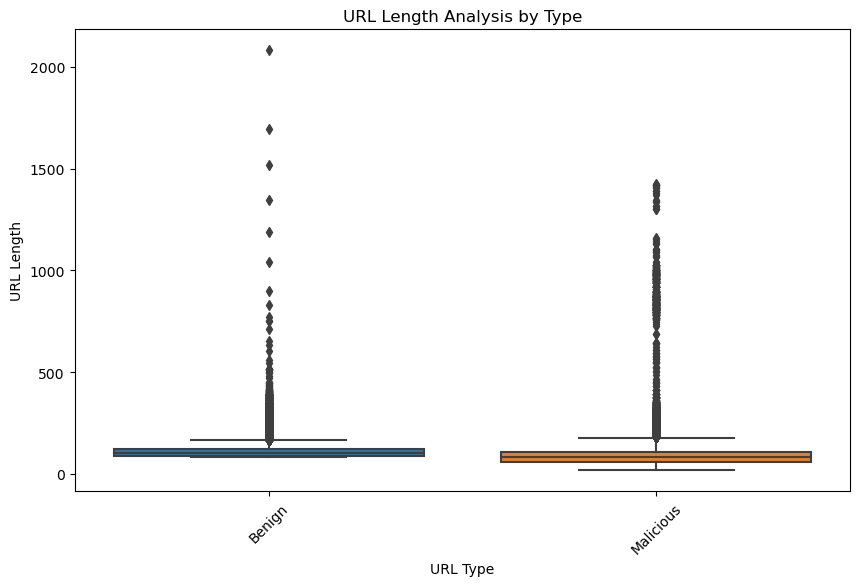

In [6]:
# 1. Frequency Distribution of URL Types
url_type_counts = data['Label'].value_counts()

# Plotting the frequency distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=url_type_counts.index, y=url_type_counts.values)
plt.title('Frequency Distribution of URL Types')
plt.xlabel('URL Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 2. URL Length Analysis
# Calculating the length of each URL
data['URL_Length'] = data['URL'].apply(len)

# Plotting URL length by type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='URL_Length', data=data)
plt.title('URL Length Analysis by Type')
plt.xlabel('URL Type')
plt.ylabel('URL Length')
plt.xticks(rotation=45)
plt.show()

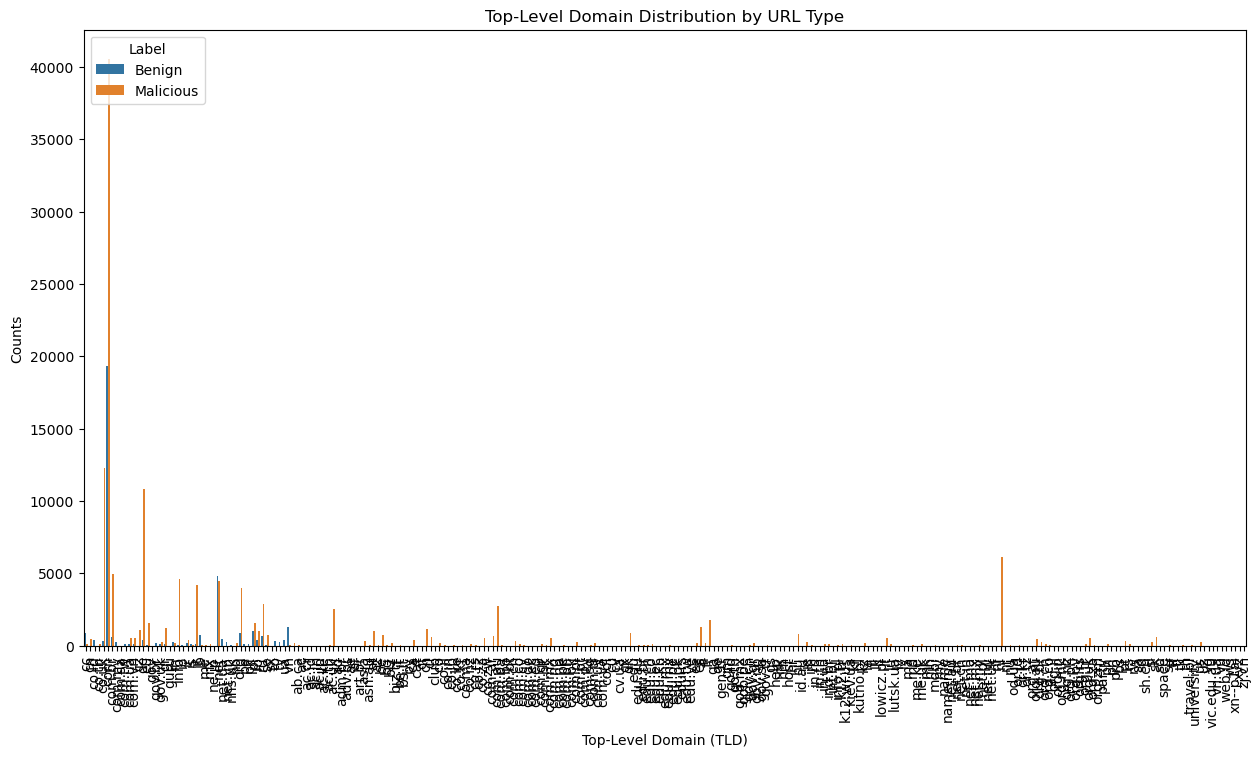

In [7]:
# Function to extract TLD from a URL
def extract_tld(url):
    extracted = tldextract.extract(url)
    return extracted.suffix

# Extracting TLDs from URLs
data['TLD'] = data['URL'].apply(extract_tld)

# Aggregating TLD counts by URL type
tld_counts = data.groupby(['Label', 'TLD']).size().reset_index(name='Counts')

# Creating a bar plot for TLD distribution for each URL type
plt.figure(figsize=(15, 8))
sns.barplot(x='TLD', y='Counts', hue='Label', data=tld_counts)
plt.title('Top-Level Domain Distribution by URL Type')
plt.xlabel('Top-Level Domain (TLD)')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

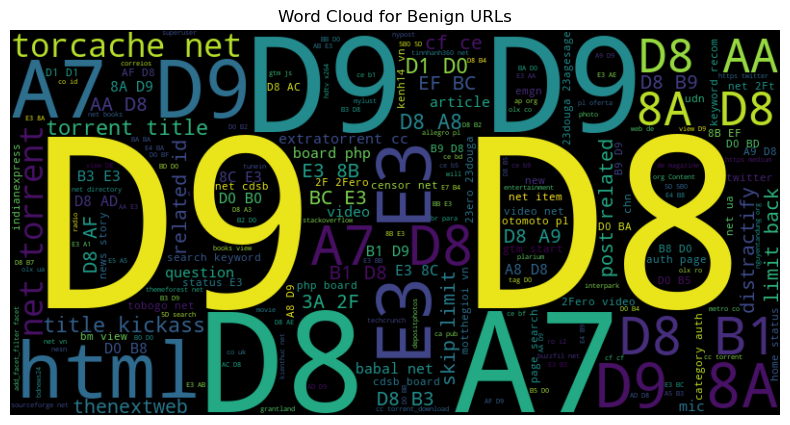

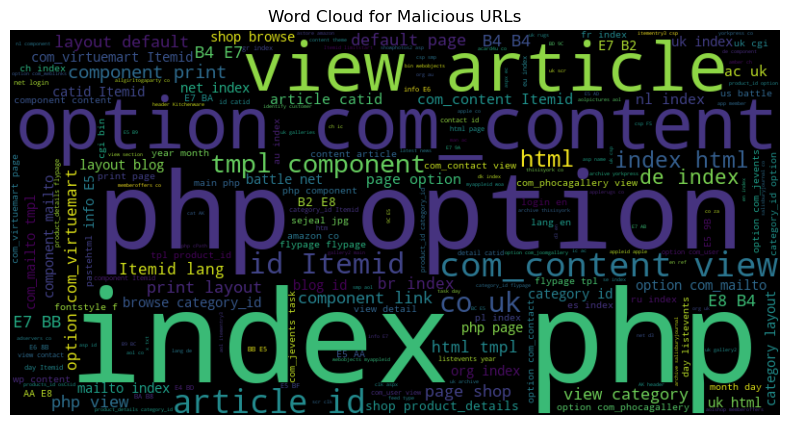

In [8]:
# Generating a word cloud for each type of URL
for label in data['Label'].unique():
    subset = data[data['Label'] == label]
    text = " ".join(url for url in subset.URL)
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    
    # Displaying the generated Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label} URLs')
    plt.axis("off")
    plt.show()

Label
Malicious    129988
Benign        35378
Name: count, dtype: int64

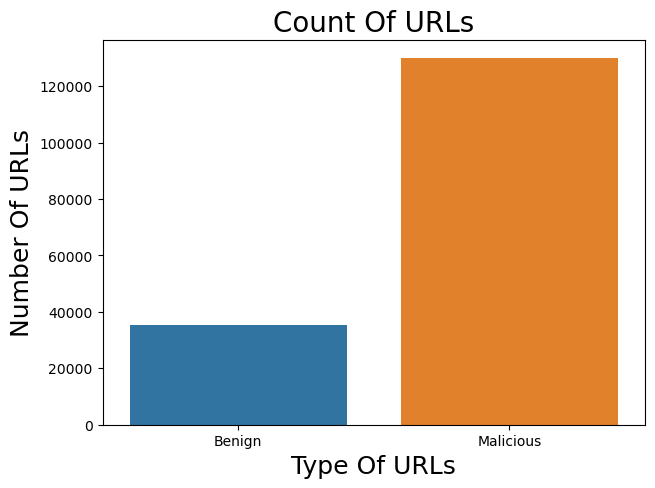

In [9]:
#checking for number of labels that are 0 and 1
plt.figure(figsize=(7,5))
sns.countplot(x='Label',data=data)
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)
data.Label.value_counts()

(0.0, 1000.0)

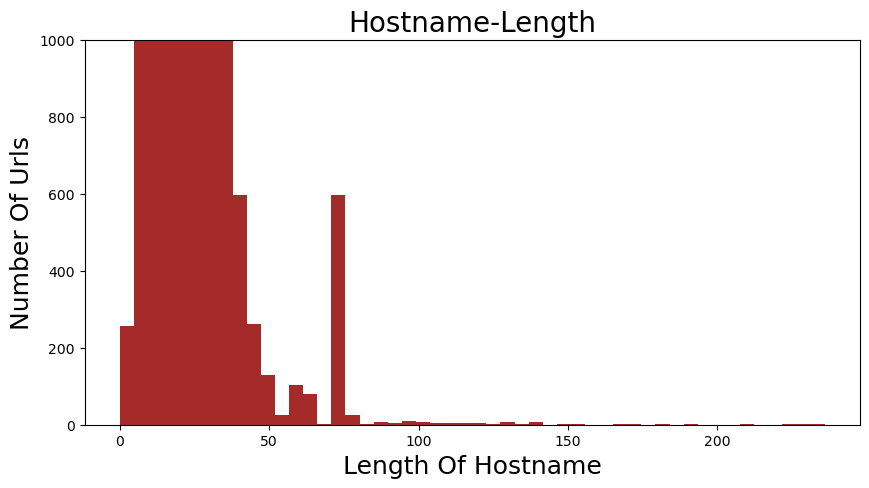

In [10]:
data['hostname_length'] = data['URL'].apply(lambda i: len(urlparse(i).netloc))
data['path_length'] = data['URL'].apply(lambda i: len(urlparse(i).path))
plt.figure(figsize=(10,5))
plt.hist(data['hostname_length'],bins=50,color='Brown')
plt.title("Hostname-Length",fontsize=20)
plt.xlabel("Length Of Hostname",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

In [11]:
def firstDir(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

data['fd_length'] = data['URL'].apply(lambda i: firstDir(i))

In [12]:
def tldf(tld):
    try:
        return len(tld)
    except:
        return -1

data['tld_length'] = data['TLD'].apply(lambda i: tldf(i))
data.head()

,URL,Label,URL_Length,TLD,hostname_length,path_length,fd_length,tld_length
0,http://1337x.to/torrent/1048648/American-Snipe...,Benign,83,to,8,68,7,2
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,Benign,83,to,8,68,7,2
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,Benign,83,to,8,68,7,2
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,Benign,83,to,8,68,7,2
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,Benign,83,to,8,68,7,2


(0.0, 1000.0)

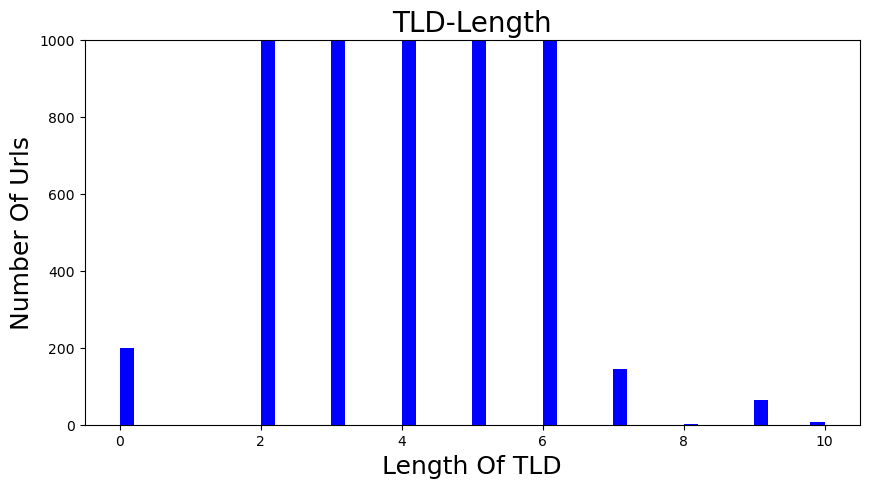

In [13]:
plt.figure(figsize=(10,5))
plt.hist(data['tld_length'],bins=50,color='Blue')
plt.title("TLD-Length",fontsize=20)
plt.xlabel("Length Of TLD",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

In [14]:
data['count-'] = data['URL'].apply(lambda i: i.count('-'))
data['count@'] = data['URL'].apply(lambda i: i.count('@'))
data['count?'] = data['URL'].apply(lambda i: i.count('?'))
data['count%'] = data['URL'].apply(lambda i: i.count('%'))
data['count.'] = data['URL'].apply(lambda i: i.count('.'))
data['count='] = data['URL'].apply(lambda i: i.count('='))
data['count-http'] = data['URL'].apply(lambda i : i.count('http'))
data['count-https'] = data['URL'].apply(lambda i : i.count('https'))
data['count-www'] = data['URL'].apply(lambda i: i.count('www'))

In [15]:
def digitCount(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
data['count-digits']= data['URL'].apply(lambda i: digitCount(i))

def letterCount(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
data['count-letters']= data['URL'].apply(lambda i: letterCount(i))



Text(0, 0.5, 'Number Of URLs')

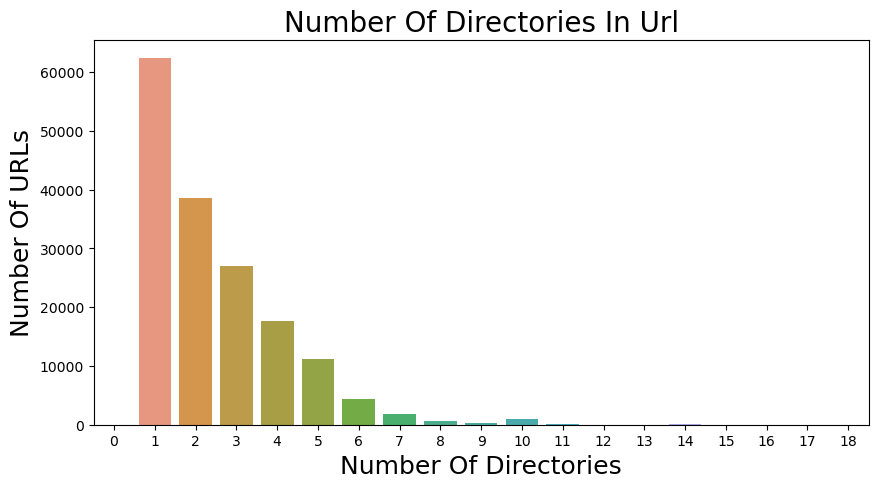

In [16]:
def numdir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
data['count_dir'] = data['URL'].apply(lambda i: numdir(i))
plt.figure(figsize=(10,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=data)
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

In [17]:
data.head() 

,URL,Label,URL_Length,TLD,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir
0,http://1337x.to/torrent/1048648/American-Snipe...,Benign,83,to,8,68,7,2,8,0,0,0,1,0,1,0,0,18,49,4
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,Benign,83,to,8,68,7,2,9,0,0,0,1,0,1,0,0,23,43,4
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,Benign,83,to,8,68,7,2,9,0,0,0,1,0,1,0,0,22,44,4
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,Benign,83,to,8,68,7,2,11,0,0,0,1,0,1,0,0,18,46,4
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,Benign,83,to,8,68,7,2,9,0,0,0,1,0,1,0,0,18,48,4


In [18]:
def haveIP(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return -1
    else:
        # print 'No matching pattern found'
        return 1
data['use_of_ip'] = data['URL'].apply(lambda i: haveIP(i))

In [19]:
def shorteningurl(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1
data['short_url'] = data['URL'].apply(lambda i: shorteningurl(i))

In [20]:
data.head()

,URL,Label,URL_Length,TLD,hostname_length,path_length,fd_length,tld_length,count-,count@,...,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,http://1337x.to/torrent/1048648/American-Snipe...,Benign,83,to,8,68,7,2,8,0,...,1,0,1,0,0,18,49,4,1,1
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,Benign,83,to,8,68,7,2,9,0,...,1,0,1,0,0,23,43,4,1,1
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,Benign,83,to,8,68,7,2,9,0,...,1,0,1,0,0,22,44,4,1,1
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,Benign,83,to,8,68,7,2,11,0,...,1,0,1,0,0,18,46,4,1,1
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,Benign,83,to,8,68,7,2,9,0,...,1,0,1,0,0,18,48,4,1,1


#  Label Encoding

In [21]:
encoder = LabelEncoder()
encoder

LabelEncoder()

In [22]:
data['Label'] = encoder.fit_transform(data['Label'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165366 entries, 0 to 165365
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   URL              165366 non-null  object
 1   Label            165366 non-null  int32 
 2   URL_Length       165366 non-null  int64 
 3   TLD              165366 non-null  object
 4   hostname_length  165366 non-null  int64 
 5   path_length      165366 non-null  int64 
 6   fd_length        165366 non-null  int64 
 7   tld_length       165366 non-null  int64 
 8   count-           165366 non-null  int64 
 9   count@           165366 non-null  int64 
 10  count?           165366 non-null  int64 
 11  count%           165366 non-null  int64 
 12  count.           165366 non-null  int64 
 13  count=           165366 non-null  int64 
 14  count-http       165366 non-null  int64 
 15  count-https      165366 non-null  int64 
 16  count-www        165366 non-null  int64 
 17  count-digi

In [23]:
data = data.drop(['TLD', 'URL'], axis=1)

<Axes: >

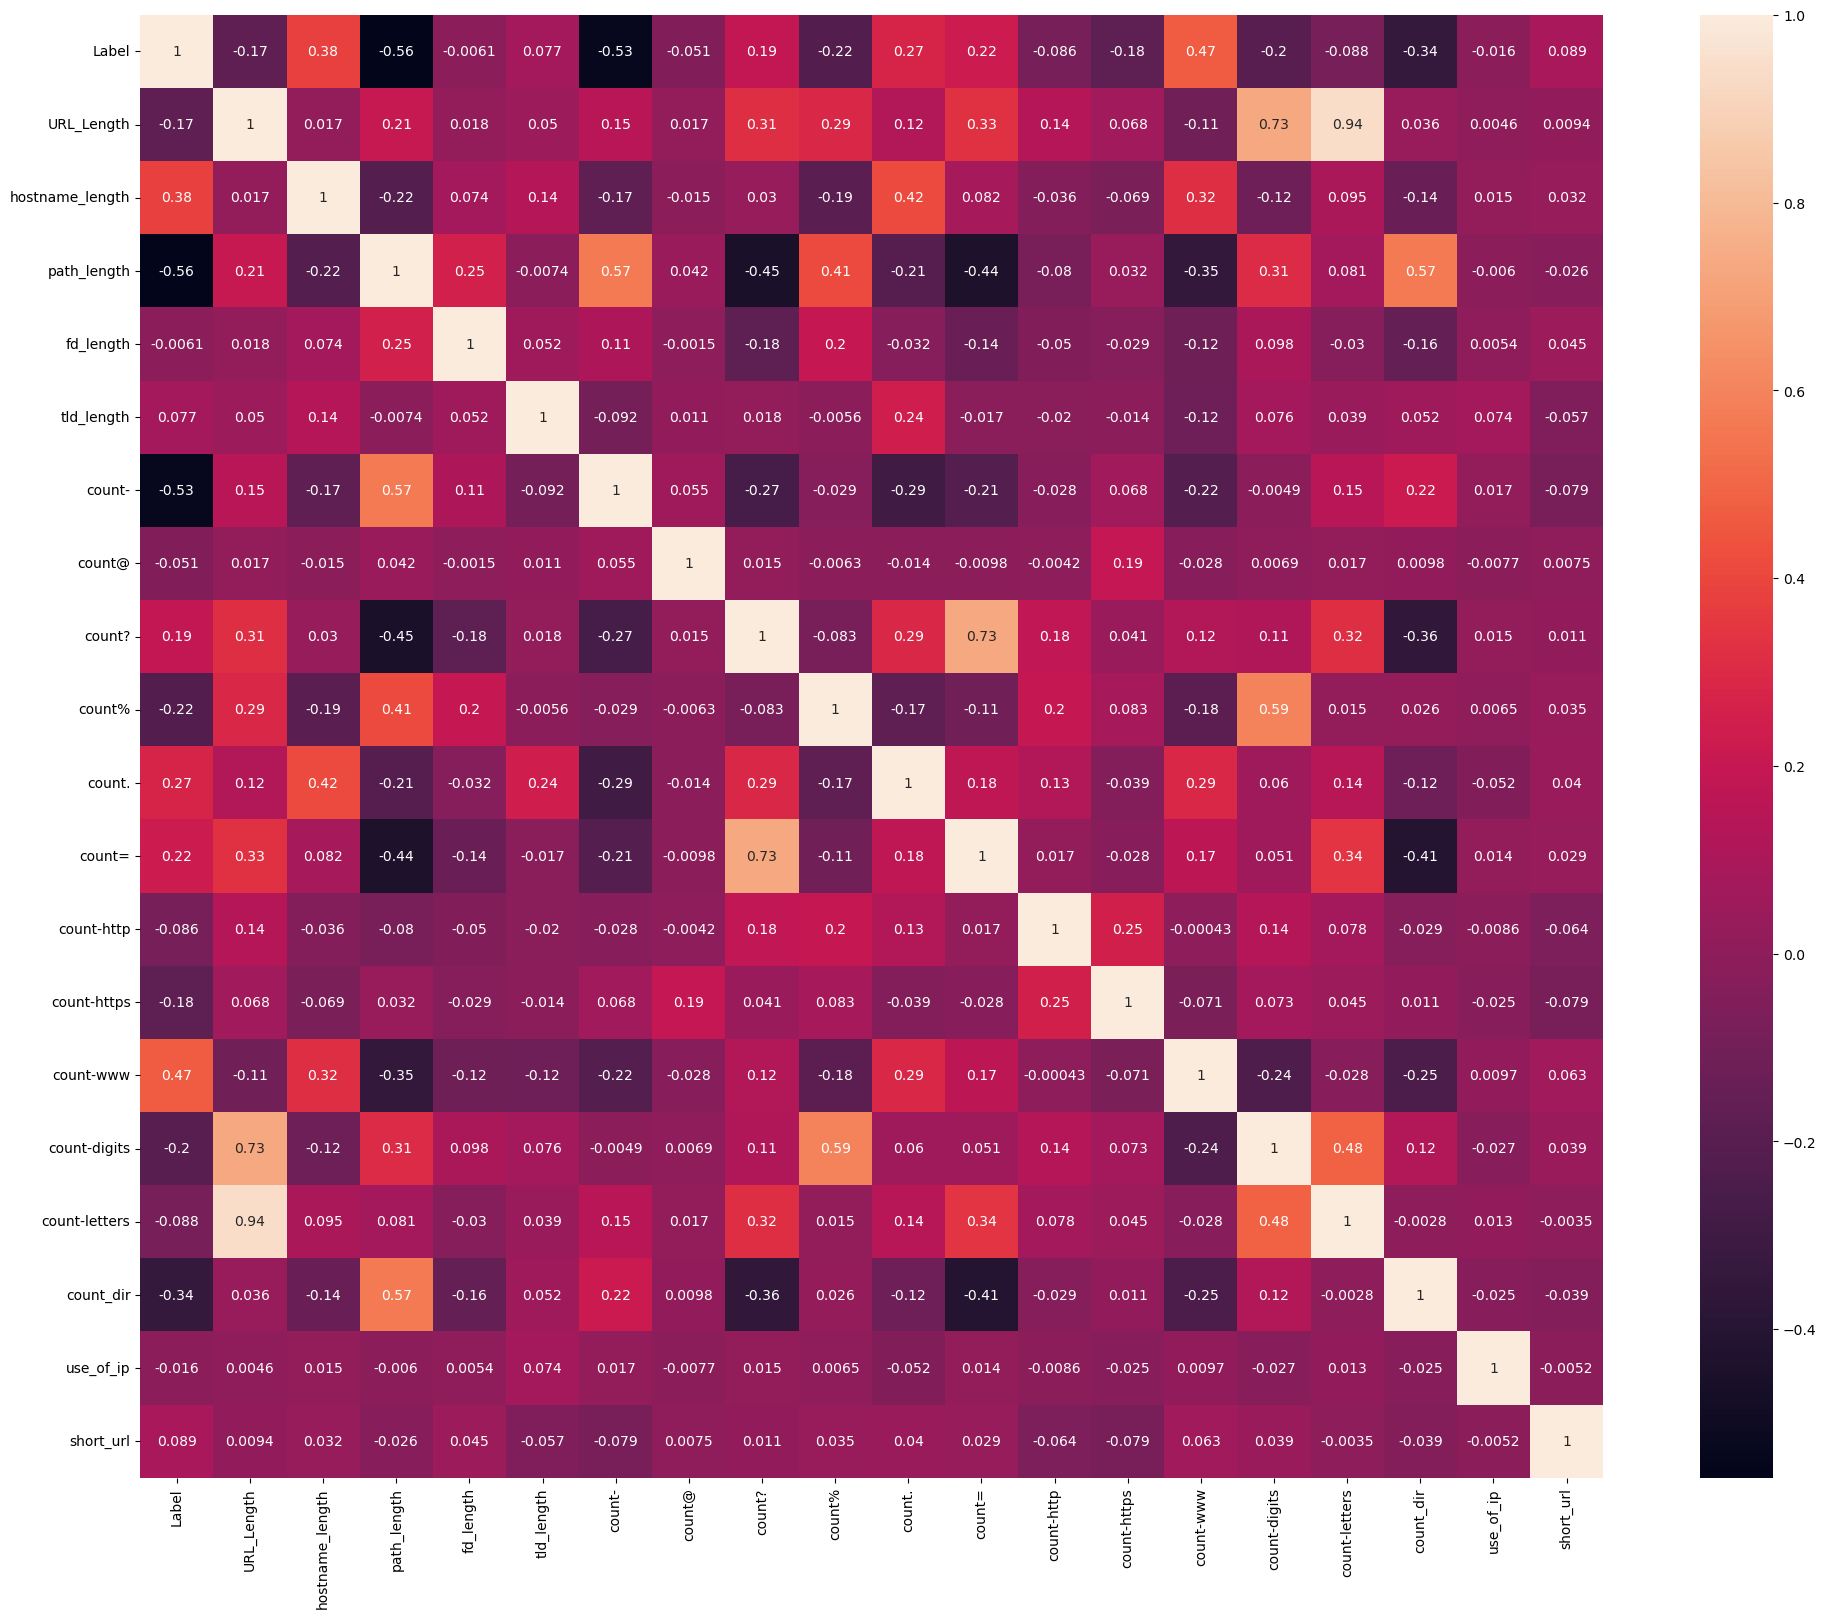

In [24]:
#checking of correlations
corrmat = data.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

In [25]:
data

,Label,URL_Length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,0,83,8,68,7,2,8,0,0,0,1,0,1,0,0,18,49,4,1,1
1,0,83,8,68,7,2,9,0,0,0,1,0,1,0,0,23,43,4,1,1
2,0,83,8,68,7,2,9,0,0,0,1,0,1,0,0,22,44,4,1,1
3,0,83,8,68,7,2,11,0,0,0,1,0,1,0,0,18,46,4,1,1
4,0,83,8,68,7,2,9,0,0,0,1,0,1,0,0,18,48,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165361,1,47,30,10,4,5,0,0,0,0,3,0,1,0,0,6,31,4,1,1
165362,1,81,19,55,16,5,2,0,0,0,3,0,1,0,0,23,46,4,1,1
165363,1,57,28,22,4,5,0,0,0,0,4,0,1,0,0,13,33,4,1,1
165364,1,116,15,22,4,5,0,0,3,0,3,4,1,0,0,25,73,2,1,1


#  Data Preparation

In [26]:
X= data.drop('Label', axis=1)
Y= data['Label']

In [27]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1)

In [28]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((148829, 19), (16537, 19), (148829,), (16537,))

#  SVM

In [29]:
svc = SVC(kernel='linear', C=5, gamma =8, max_iter = 2)

In [30]:
svc.fit(trainX, trainY)
ypred = svc.predict(testX)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [31]:
accuracySVM = accuracy_score(testY, ypred.round())  *100
f1SVM = f1_score(testY, ypred.round(), average='macro') *100
print(accuracySVM, f1SVM)

79.05907963959605 46.76639507853137


#  Random Forest Trees

In [32]:
rft = RandomForestClassifier()

In [33]:
rft.fit(trainX, trainY)
ypred = rft.predict(testX)

In [34]:
accuracyRFT = accuracy_score(testY, ypred.round())  *100
f1RFT = f1_score(testY, ypred.round(), average='macro') *100
print(accuracyRFT, f1RFT)

99.78835338936929 99.6833132773374


#  XGBoost

In [35]:
xgb = XGBClassifier()

In [36]:
xgb.fit(trainX, trainY)
ypred = xgb.predict(testX)

In [37]:
accuracyXGB = accuracy_score(testY, ypred.round())  *100
f1XGB = f1_score(testY, ypred.round(), average='macro') *100
print(accuracyXGB, f1XGB)

99.81254157344137 99.71938903906317


#  AdaBoost 

In [38]:
ada = AdaBoostClassifier()

In [39]:
ada.fit(trainX, trainY)
ypred = ada.predict(testX)

In [40]:
accuracyADA = accuracy_score(testY, ypred.round())  *100
f1ADA = f1_score(testY, ypred.round(), average='macro') *100
print(accuracyADA, f1ADA)

97.39372316623329 96.14731622052257


#  Logistic Regression

In [41]:
lr = LogisticRegression(C=100)

In [42]:
lr.fit(trainX, trainY)
ypred = lr.predict(testX)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
accuracyLR = accuracy_score(testY, ypred.round())  *100
f1LR = f1_score(testY, ypred.round(), average='macro') *100
print(accuracyLR, f1LR)

92.6044627199613 88.70087572615365


# Reshaping data for Deep Learning Models

In [44]:
trainX = trainX.to_numpy().reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.to_numpy().reshape((testX.shape[0], testX.shape[1], 1))
trainY = trainY.to_numpy()
testY = testY.to_numpy()
trainX.shape, testX.shape, trainY.shape, testY.shape

((148829, 19, 1), (16537, 19, 1), (148829,), (16537,))

# LSTM

In [45]:
lstm = Sequential()
lstm.add(LSTM(units=64,activation = 'tanh', return_sequences = True, input_shape = (trainX.shape[1],1)))
lstm.add(Flatten())
lstm.add(Dropout(0.1))
lstm.add(Dense(1, activation='sigmoid'))

In [46]:
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1)

In [47]:
# Training the model
lstm.fit(trainX, trainY, batch_size=2048,epochs=10, callbacks=[es])
ypred = lstm.predict(testX, verbose=1)

Epoch 1/10


73/73 [==============================] - 9s 84ms/step - loss: 0.4164 - accuracy: 0.8028
Epoch 2/10
73/73 [==============================] - 7s 90ms/step - loss: 0.2139 - accuracy: 0.9080
Epoch 3/10
73/73 [==============================] - 6s 87ms/step - loss: 0.1746 - accuracy: 0.9269
Epoch 4/10
73/73 [==============================] - 6s 86ms/step - loss: 0.1470 - accuracy: 0.9391
Epoch 5/10
73/73 [==============================] - 6s 85ms/step - loss: 0.1303 - accuracy: 0.9471
Epoch 6/10
73/73 [==============================] - 6s 88ms/step - loss: 0.1152 - accuracy: 0.9545
Epoch 7/10
73/73 [==============================] - 7s 90ms/step - loss: 0.1061 - accuracy: 0.9587
Epoch 8/10
73/73 [==============================] - 7s 90ms/step - loss: 0.0984 - accuracy: 0.9615
Epoch 9/10
73/73 [==============================] - 6s 83ms/step - loss: 0.0950 - accuracy: 0.9635
Epoch 10/10
517/517 [==============================] - 2s 3ms/step


In [48]:
accuracyLSTM = accuracy_score(testY, ypred.round())  *100
f1LSTM = f1_score(testY, ypred.round(), average='micro') *100
print(accuracyLSTM, f1LSTM)

96.6197012759267 96.6197012759267


# RNN

In [49]:
rnn = Sequential()
rnn.add(SimpleRNN(units=128,activation = 'relu', return_sequences = True, input_shape = (trainX.shape[1],1)))
rnn.add(Flatten())
rnn.add(Dropout(0.5))
rnn.add(Dense(1, activation='sigmoid'))

In [50]:
rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1)

In [51]:
# Training the model
rnn.fit(trainX, trainY, batch_size=2048,epochs=10, callbacks=[es])
ypred = rnn.predict(testX, verbose=1)

Epoch 1/10
73/73 [==============================] - 7s 76ms/step - loss: 0.9104 - accuracy: 0.8113
Epoch 2/10
73/73 [==============================] - 5s 74ms/step - loss: 0.3200 - accuracy: 0.9004
Epoch 3/10
73/73 [==============================] - 6s 77ms/step - loss: 0.1889 - accuracy: 0.9331
Epoch 4/10
73/73 [==============================] - 5s 75ms/step - loss: 0.1368 - accuracy: 0.9509
Epoch 5/10
73/73 [==============================] - 5s 72ms/step - loss: 0.1090 - accuracy: 0.9621
Epoch 6/10
73/73 [==============================] - 5s 72ms/step - loss: 0.0917 - accuracy: 0.9687
Epoch 7/10
73/73 [==============================] - 5s 72ms/step - loss: 0.0773 - accuracy: 0.9736
Epoch 8/10
73/73 [==============================] - 5s 72ms/step - loss: 0.0636 - accuracy: 0.9788
Epoch 9/10
73/73 [==============================] - 5s 72ms/step - loss: 0.0591 - accuracy: 0.9806
Epoch 10/10
517/517 [==============================] - 1s 2ms/step


In [52]:
accuracyRNN = accuracy_score(testY, ypred.round()) *100
f1RNN = f1_score(testY, ypred.round(), average='macro') *100
print(accuracyRNN, f1RNN)

98.48219144947693 97.75266619286694


#  Results

In [53]:
result = pd.DataFrame({'Model':['SVM', 'Random Forest Trees', 'XGBoost', 'AdaBoost', 'Logistic Regression', 'LSTM', 'RNN'],
                      'Accuracy':[accuracySVM, accuracyRFT, accuracyXGB, accuracyADA, accuracyLR, accuracyLSTM, accuracyRNN],
                      'F1-Score':[f1SVM, f1RFT, f1XGB, f1ADA, f1LR, f1LSTM, f1RNN]})

In [54]:
result

,Model,Accuracy,F1-Score
0,SVM,79.059080,46.766395
1,Random Forest Trees,99.788353,99.683313
2,XGBoost,99.812542,99.719389
3,AdaBoost,97.393723,96.147316
4,Logistic Regression,92.604463,88.700876
5,LSTM,96.619701,96.619701
6,RNN,98.482191,97.752666


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'SVM'),
  Text(1, 0, 'Random Forest Trees'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'AdaBoost'),
  Text(4, 0, 'Logistic Regression'),
  Text(5, 0, 'LSTM'),
  Text(6, 0, 'RNN')])

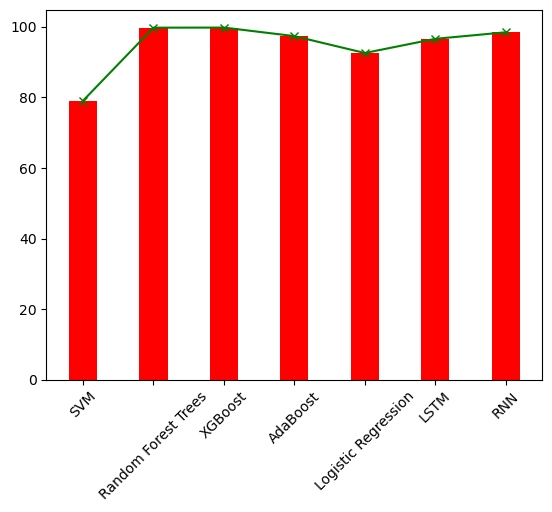

In [55]:
# creating the bar plot
plt.bar(result['Model'], result['Accuracy'], color ='red', width = 0.4)
plt.plot(result['Model'], result['Accuracy'], color ='green', marker='x')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'SVM'),
  Text(1, 0, 'Random Forest Trees'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'AdaBoost'),
  Text(4, 0, 'Logistic Regression'),
  Text(5, 0, 'LSTM'),
  Text(6, 0, 'RNN')])

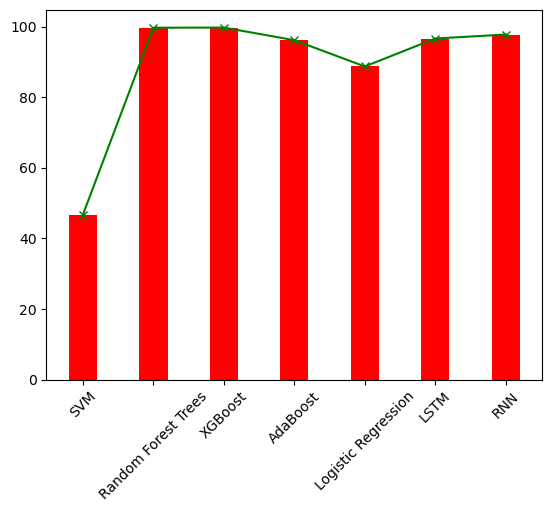

In [56]:
# creating the bar plot
plt.bar(result['Model'], result['F1-Score'], color ='red', width = 0.4)
plt.plot(result['Model'], result['F1-Score'], color ='green', marker='x')
plt.xticks(rotation=45)

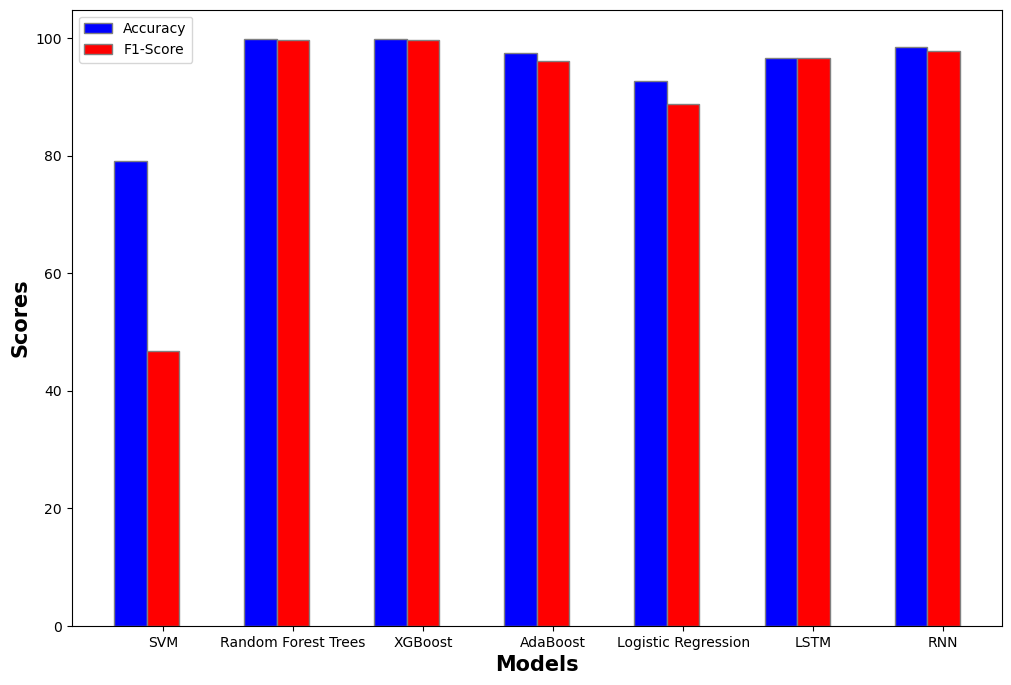

In [57]:
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(result))
br2 = [x + 0.25 for x in br1]

plt.bar(br1, result['Accuracy'], color ='b', width = 0.25, edgecolor ='grey', label ='Accuracy')
plt.bar(br2, result['F1-Score'], color ='r', width = 0.25, edgecolor ='grey', label ='F1-Score')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Scores', fontweight ='bold', fontsize = 15)
plt.xticks([r + 0.25 for r in range(len(result))], result['Model'])
 
plt.legend()
plt.show()

In [58]:
result.sort_values(by=['Accuracy'], ascending=False)

,Model,Accuracy,F1-Score
2,XGBoost,99.812542,99.719389
1,Random Forest Trees,99.788353,99.683313
6,RNN,98.482191,97.752666
3,AdaBoost,97.393723,96.147316
5,LSTM,96.619701,96.619701
4,Logistic Regression,92.604463,88.700876
0,SVM,79.059080,46.766395


In [59]:
pickle.dump(xgb, open('bestModel.pkl','wb'))